# Step 03
# Predict segmentations

In [1]:
%matplotlib inline

In [2]:
import os
import os.path

import matplotlib.pyplot as plt
import numpy as np

import skimage.io
import skimage.morphology

import tensorflow as tf
import keras

import utils.metrics
import utils.model_builder

Using TensorFlow backend.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15718657661789251964
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10915282944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4853009080100336356
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


# Configuration

In [43]:
from my_config import config_vars

# Partition of the data to make predictions (test or validation)
partition = "validation"

experiment_name = '00'

config_vars["root_directory"] = 'CELL/seg_samples_KZ_images/'

config_vars = utils.dirtools.setup_working_directories(config_vars)
config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

In [44]:
config_vars

{'root_directory': 'CELL/seg_samples_KZ_images/',
 'max_training_images': 0,
 'create_split_files': True,
 'training_fraction': 0.8,
 'validation_fraction': 0.1,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': 'CELL/seg_samples_KZ_images/raw_images/',
 'raw_annotations_dir': 'CELL/seg_samples_KZ_images/raw_annotations/',
 'path_files_training': 'CELL/seg_samples_KZ_images/training.txt',
 'path_files_validation': 'CELL/seg_samples_KZ_images/validation.txt',
 'path_files_test': 'CELL/seg_samples_KZ_images/test.txt',
 'normalized_images_dir': 'CELL/seg_samples_KZ_images/norm_images/',
 'boundary

In [45]:
config_vars['model_file'] = 'CELL/FISH/experiments/00/model.hdf5'

In [46]:
def create_image_lists(dir_raw_images):
    file_list = os.listdir(dir_raw_images)

    image_list = [x for x in file_list if x.endswith("png")]
    image_list = sorted(image_list)

    image_list_validation = image_list
    image_list_test = []
    image_list_train = []
    image_list_train_aug = []

    return image_list_train, image_list_test, image_list_validation, image_list_train_aug

In [47]:
[list_training, list_test, list_validation, list_training_aug] = create_image_lists(
    config_vars["normalized_images_dir"]
)

utils.dirtools.write_path_files(config_vars["path_files_training"], list_training)
utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)
utils.dirtools.write_path_files(config_vars["path_files_validation"], list_validation)

# modify the write path method to add 'raw_masks/' ahead of the name
# utils.dirtools.write_path_files2(config_vars["path_files_training_aug"], list_training_aug)

In [48]:
# need to creat split file first
data_partitions = utils.dirtools.read_data_partitions(config_vars)

In [49]:
# Device configuration

# Use the following configuration if you want to test on CPUs
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# configuration = tf.ConfigProto(
#       intra_op_parallelism_threads=1,
#       inter_op_parallelism_threads=1)

# Configuration to run on GPU
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
# configuration.gpu_options.visible_device_list = "2"

session = tf.Session(config = configuration)

# apply session
keras.backend.set_session(session)

# Load images and run predictions

In [50]:
import warnings
warnings.filterwarnings("ignore")

In [51]:
#image_names = [f for f in data_partitions[partition] if f.startswith("IXM")]
image_names = [os.path.join(config_vars["normalized_images_dir"], f) for f in data_partitions[partition]]

imagebuffer = skimage.io.imread_collection(image_names)

images = imagebuffer.concatenate()

dim1 = images.shape[1]
dim2 = images.shape[2]

images = images.reshape((-1, dim1, dim2, 1))

# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images = images / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
model.load_weights(config_vars["model_file"])

# Normal prediction time
predictions = model.predict(images, batch_size=1)

# model.summary()

# Transform predictions to label matrices

0000.png


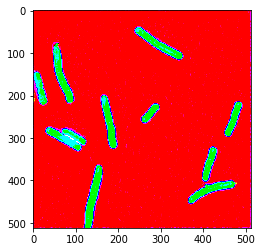

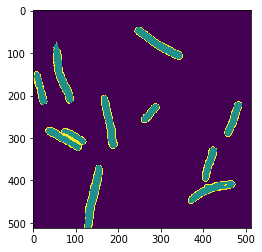

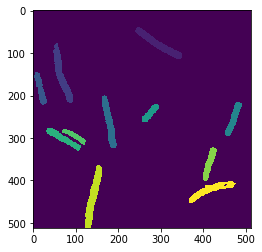

0001.png


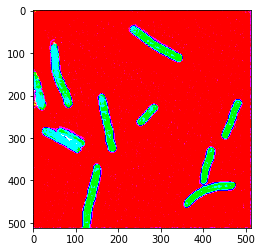

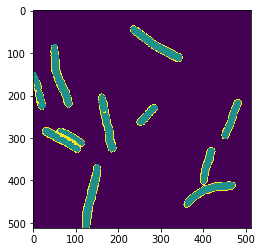

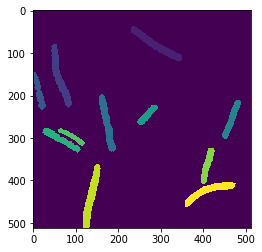

0002.png


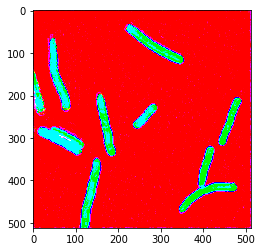

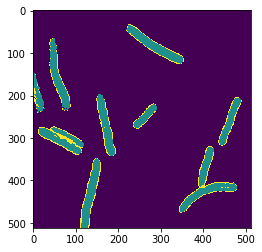

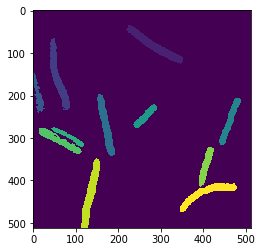

0003.png


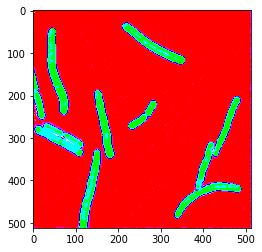

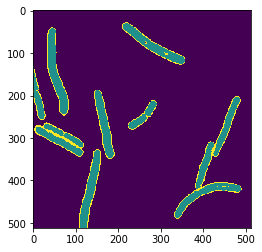

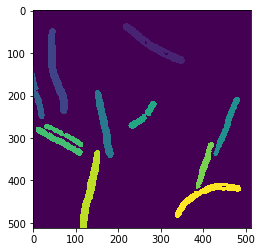

0004.png


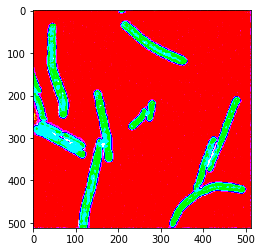

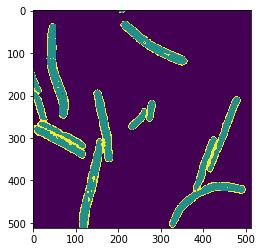

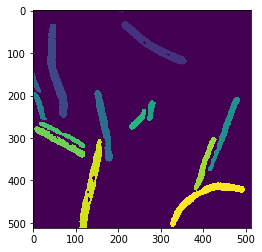

0005.png


0006.png


0007.png


0008.png


0009.png


0010.png


0011.png


0012.png


0013.png


0014.png


0015.png


0016.png


0017.png


0018.png


0019.png


0020.png


0021.png


0022.png


0023.png


0024.png


0025.png


0026.png


0027.png


0028.png


0029.png


0030.png


0031.png


0032.png


0033.png


0034.png


0035.png


0036.png


0037.png


0038.png


0039.png


0040.png


0041.png


0042.png


0043.png


0044.png


0045.png


0046.png


0047.png


0048.png


0049.png


0050.png


0051.png


0052.png


0053.png


0054.png


0055.png


0056.png


0057.png


0058.png


0059.png


0060.png


0061.png


0062.png


0063.png


0064.png


0065.png


0066.png


0067.png


0068.png


0069.png


0070.png


0071.png


0072.png


0073.png


0074.png


In [52]:
for i in range(len(images)):

    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
    
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])
    
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    
    skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)
    
    if (i < 5):
        plt.imshow(probmap)
        plt.show()
        plt.imshow(pred)
        plt.show()
        plt.imshow(label)
        plt.show() 
